# Regressione Logistica utilizzando TensorFlow

In questa sezione, applichiamo la **regressione logistica**, un modello di apprendimento supervisionato comunemente utilizzato per la classificazione binaria. La regressione logistica stima la probabilità che un dato input appartenga a una delle due classi, utilizzando la funzione sigmoid per mappare i valori della funzione lineare a un intervallo compreso tra 0 e 1. In particolare, si cerca di predire se il reddito di un individuo superi i 50.000 dollari, basandosi su vari attributi delle persone, come l'età, l'istruzione e lo stato civile.

Il modello che implementiamo è rappresentato dalla classe `LogisticRegression`, che include metodi per calcolare i logit (i valori non trasformati della funzione sigmoid), ottimizzare i pesi del modello tramite la discesa del gradiente e valutare le metriche di performance come la loss e l'accuratezza.



In [2]:
from types import SimpleNamespace

from Tools.scripts.generate_re_casefix import alpha

from data import get_adult

import tensorflow as tf
import numpy as np 
import random
import matplotlib.pyplot as plt


In [19]:
class LogisticRegression():
    def __init__(self,
                 d,  # Dimension of the input vector
                 lr,  # learning rate
                 momentum,  # momentum
                 nesterov,  # NAG (if True) or classic momentum (False)
                 batch_size,  # Batch size
                 num_epochs,  # number of cycles through the whole training set
                 seed,  # !=0 to reproduce from run to run
                 ):
        # lock the seed for reproducibility
        tf.random.set_seed(seed)
        self.d = d
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        # Declare parameters as tensorflow variables
        self.w = tf.Variable(tf.random.normal(shape=[d, 1]), name='w')
        self.b = tf.Variable(tf.random.normal(shape=[1, 1]), name='b')
        self.optimizer = tf.optimizers.SGD(
            learning_rate=lr,
            momentum=momentum,
            nesterov=nesterov)
        
        self.losses = []
        self.accs = []
        self.losses_batch = []
        self.accs_batch = []

    def _compute_logits(self, X):
        f = tf.matmul(X, self.w) + self.b 
        return f
    
    def _step(self, X, y):
        with tf.GradientTape() as tape:
            f = self._compute_logits(X)
            loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=f, labels=y)  # calcolo della loss passando i logits e labels
            loss = tf.reduce_mean(loss)  # media su tutti gli elementi del mini batch
        gradients = tape.gradient(loss, [self.w, self.b])  # recupero il gradiente
        self.optimizer.apply_gradients(zip(gradients, [self.w, self.b]))  # applico gradiente
        prediction = tf.round(tf.sigmoid(f))  # 1 se > 0.5, altrimenti 0
        correct = tf.cast(tf.equal(prediction, y), dtype=tf.float32) 
        accuracy = tf.reduce_mean(correct)
        return loss, accuracy
    
    def _metrics(self, X, y):  # serve per vedere l'andamento dell'ottimizzazione con Tensorboard
        f = self._compute_logits(X)
        loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=f, labels=y)
        loss = tf.reduce_mean(loss)
        prediction = tf.round(tf.sigmoid(f))
        correct = tf.cast(tf.equal(prediction, y), dtype=tf.float32)
        accuracy = tf.reduce_mean(correct)
        return loss, accuracy
    
    def fit(self, X_train, y_train, X_test, y_test): 
        n, d = X_train.shape
        assert d == self.d  # controllo che le dimensioni siano corrette a runtime
        random.seed(1234)
        
        # TensorBoard writers per monitorare loss e accuracy
        # Commentati per disabilitare TensorBoard
        # train_summary_writer = tf.summary.create_file_writer('tensorboard/log_regr/train')
        # test_summary_writer = tf.summary.create_file_writer('tensorboard/log_regr/test')
        
        for epoch in range(self.num_epochs): 
            idx = list(range(n))  # lista di indici, n = dimensione training set
            random.shuffle(idx)  # mescolo la lista con metodo random shuffle (visto a lezione)
            losses, accs = [], []  # per salvare loss e accuracy dei mini batch
            num_batches = n // self.batch_size 
            for b in range(num_batches):
                mb_idx = np.array(idx[b * self.batch_size:(b + 1) * self.batch_size])  # prendo un sottoinsieme di indici per il mini batch
                X_mb = X_train[mb_idx]  # estraggo input
                y_mb = np.matrix(y_train[mb_idx]).T  # estraggo label
                loss, acc = self._step(X_mb, y_mb)  # eseguo uno step di ottimizzazione
                losses.append(loss)
                accs.append(acc)
            print(f"Epoch: {epoch + 1:4d}", end=" ")
            print(f"Loss: {np.array(losses).mean():.5f}", end=" ")
            print(f"Acc: {100 * np.array(accs).mean():.2f}%")
            
            self.losses.append(np.array(losses).mean())
            self.accs.append(100 * np.array(accs).mean())
            self.losses_batch.append(losses)
            self.accs_batch.append(100 * np.array(accs))
            
            # Scrittura dei risultati su TensorBoard
            # Commentati per disabilitare TensorBoard
            # with train_summary_writer.as_default(): 
            #     loss, acc = self._metrics(X_train, np.matrix(y_train).T)
            #     tf.summary.scalar('loss', loss, step=epoch)
            #     tf.summary.scalar('accuracy', acc, step=epoch)
            # with test_summary_writer.as_default():
            #     loss, acc = self._metrics(X_test, np.matrix(y_test).T)
            #     tf.summary.scalar('loss', loss, step=epoch)
            #     tf.summary.scalar('accuracy', acc, step=epoch)
                
    def predict(self, X_np):  # fa inferenza sul test set calcolando i logits
        n, d = X_np.shape
        assert d == self.d
        pred = self._compute_logits(X_np)
        return (pred > 0).numpy().flatten()
    

# Definisci le tue opzioni direttamente qui
opts = SimpleNamespace(
    datafile='adult.csv',
    lr=0.01,
    momentum=0.95,
    nesterov=False,
    batch_size=1024,
    num_epochs=32,
    seed=1234
)

# Carica il dataset
X_train, y_train, X_test, y_test = get_adult(opts.datafile)

# Costruisci il modello recuperando parametri da opts
clf = LogisticRegression(
    d=X_train.shape[1],
    lr=opts.lr,
    momentum=opts.momentum,
    nesterov=opts.nesterov,
    batch_size=opts.batch_size,
    num_epochs=opts.num_epochs,
    seed=opts.seed
)

# Esegui il fit e la previsione
clf.fit(X_train, y_train, X_test, y_test)
pred = clf.predict(X_test)
print(f'Test set accuracy: {np.mean(pred == y_test) * 100:.2f}%')


Epoch:    1 Loss: 0.91138 Acc: 63.44%
Epoch:    2 Loss: 0.49737 Acc: 78.04%
Epoch:    3 Loss: 0.44679 Acc: 80.56%
Epoch:    4 Loss: 0.43260 Acc: 81.08%
Epoch:    5 Loss: 0.41908 Acc: 81.36%
Epoch:    6 Loss: 0.40935 Acc: 81.70%
Epoch:    7 Loss: 0.40047 Acc: 81.98%
Epoch:    8 Loss: 0.39223 Acc: 82.24%
Epoch:    9 Loss: 0.38663 Acc: 82.35%
Epoch:   10 Loss: 0.38094 Acc: 82.57%
Epoch:   11 Loss: 0.37505 Acc: 82.81%
Epoch:   12 Loss: 0.37152 Acc: 82.94%
Epoch:   13 Loss: 0.36769 Acc: 83.07%
Epoch:   14 Loss: 0.36421 Acc: 83.23%
Epoch:   15 Loss: 0.36136 Acc: 83.36%
Epoch:   16 Loss: 0.35958 Acc: 83.47%
Epoch:   17 Loss: 0.35676 Acc: 83.56%
Epoch:   18 Loss: 0.35473 Acc: 83.67%
Epoch:   19 Loss: 0.35246 Acc: 83.76%
Epoch:   20 Loss: 0.35139 Acc: 83.82%
Epoch:   21 Loss: 0.34910 Acc: 83.87%
Epoch:   22 Loss: 0.34832 Acc: 83.94%
Epoch:   23 Loss: 0.34700 Acc: 84.04%
Epoch:   24 Loss: 0.34564 Acc: 84.08%
Epoch:   25 Loss: 0.34454 Acc: 84.15%
Epoch:   26 Loss: 0.34360 Acc: 84.22%
Epoch:   27 

## Grafici
Nella sezione seguente, vengono mostrati due grafici che rappresentano l'andamento della **loss** durante l'addestramento del modello. In particolare, il primo grafico mostra la **Batch Loss**, tracciata con una linea tratteggiata e un livello di trasparenza per evidenziare le fluttuazioni delle singole iterazioni, mentre il secondo grafico rappresenta la **Mean Loss** (o loss media) con una linea continua. Questo grafico fornisce una visione più stabile e generale dell'andamento della loss attraverso le epoche. La legenda evidenzia chiaramente i due andamenti, consentendo un confronto visivo diretto tra la perdita media e le perdite calcolate in ciascun batch.

Analogamente, vengono presentati anche due grafici che illustrano l'andamento dell'**accuratezza** del modello durante l'addestramento. Il primo grafico rappresenta l'**accuratezza per ogni epoca**, tracciata con una linea continua, che fornisce una visione chiara delle prestazioni complessive del modello nel tempo. Il secondo grafico mostra l'**accuratezza su batch** con una linea tratteggiata e un livello di trasparenza, evidenziando le variazioni di accuratezza che possono verificarsi tra i vari batch durante il processo di addestramento. Questo confronto consente di analizzare come l'accuratezza media si stabilizza rispetto alle fluttuazioni di accuratezza osservate in ciascun batch, fornendo così un quadro completo delle prestazioni del modello.

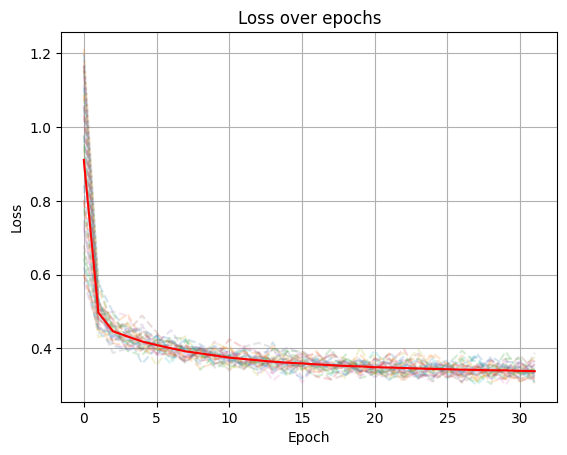

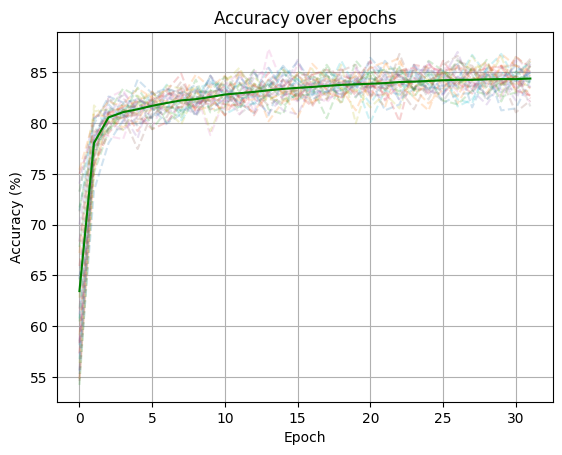

In [20]:
# Grafico della Loss
plt.figure()  
x = [i for i in range(opts.num_epochs)]
y1 = clf.losses 
y2 = clf.losses_batch
plt.plot(x, y2, linestyle = '--', alpha = 0.2)
plt.plot(x, y1, color = 'red')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.show()  # Mostra il grafico della Loss

# Grafico dell'Accuracy
plt.figure() 
y1 = clf.accs
y2 = clf.accs_batch
plt.plot(x, y2, linestyle = '--', alpha = 0.2)
plt.plot(x, y1, color = 'green')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over epochs')
plt.show()  # Mostra il grafico dell'Accuracy
